In [ ]:
import os
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

# Nov 30

##  incorporating Attention Mechanisms (Spatial and Channel Attention)

In [3]:
def load_all_npy_files(base_folder, num_simulations, load_files=("checkerboard", "displacements"), skip_missing=True):
    """
    Load specified .npy files from multiple simulation folders.

    Args:
        base_folder (str): The base folder containing simulation subfolders.
        num_simulations (int): The number of simulations (Simulation_0 to Simulation_(num_simulations-1)).
        load_files (tuple): Names of the files to load (default: ("checkerboard", "displacements")).
        skip_missing (bool): If True, skip missing files; otherwise, raise an error.

    Returns:
        dict: A dictionary containing loaded data arrays for the specified files.
              Keys are file names, and values are stacked arrays.
    """
    # Initialize dictionaries to store data
    data_dict = {key: [] for key in load_files}

    for i in range(num_simulations):
        simulation_folder = f"Simulation_{i}"  # Dynamically construct folder name
        simulation_path = os.path.join(base_folder, simulation_folder)

        for file_name in load_files:
            data_file_path = os.path.join(simulation_path, f"{file_name}.npy")

            if os.path.exists(data_file_path):
                # Load the file and append to the respective list
                data_dict[file_name].append(np.load(data_file_path))
                print(f"{file_name.capitalize()} from {simulation_folder} loaded successfully!")
            else:
                # Handle missing files
                if skip_missing:
                    print(f"{file_name.capitalize()} File not found in {simulation_folder}! Skipping...")
                else:
                    raise FileNotFoundError(f"{file_name.capitalize()} File not found in {simulation_folder}!")

    # Stack data from all simulations along a new axis
    stacked_data = {}
    for key, data_list in data_dict.items():
        if data_list:
            stacked_data[key] = np.stack(data_list)  # Stack along a new axis
        else:
            stacked_data[key] = None  # No data loaded for this key

    print("All specified data loaded and stacked successfully!")
    return stacked_data

# Base folder and number of simulations
data_path1 = r"C:\Users\Lenovo\Desktop\CSE 583 Software Development for Data Scientists\Project\Dataset1_Random_Board\Dataset1_Random_Board"
num_simulations1 = 1531  # Adjust based on your dataset

# Call the function and specify the files to load
loaded_data1 = load_all_npy_files(data_path1, num_simulations1, load_files=("checkerboard", "displacements"))

# Access the returned data
checkerboard1 = loaded_data1["checkerboard"]
displacements1 = loaded_data1["displacements"]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27020\1803162784.py:27: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  data_dict[file_name].append(np.load(data_file_path))


Checkerboard from Simulation_0 loaded successfully!
Displacements from Simulation_0 loaded successfully!
Checkerboard from Simulation_1 loaded successfully!
Displacements from Simulation_1 loaded successfully!
Checkerboard from Simulation_2 loaded successfully!
Displacements from Simulation_2 loaded successfully!
Checkerboard from Simulation_3 loaded successfully!
Displacements from Simulation_3 loaded successfully!
Checkerboard from Simulation_4 loaded successfully!
Displacements from Simulation_4 loaded successfully!
Checkerboard from Simulation_5 loaded successfully!
Displacements from Simulation_5 loaded successfully!
Checkerboard from Simulation_6 loaded successfully!
Displacements from Simulation_6 loaded successfully!
Checkerboard from Simulation_7 loaded successfully!
Displacements from Simulation_7 loaded successfully!
Checkerboard from Simulation_8 loaded successfully!
Displacements from Simulation_8 loaded successfully!
Checkerboard from Simulation_9 loaded successfully!
Dis

Epoch 1/10, Training Loss: 0.0005623986, Validation Loss: 0.0000331212
Epoch 2/10, Training Loss: 0.0000122464, Validation Loss: 0.0000168709
Epoch 3/10, Training Loss: 0.0000060300, Validation Loss: 0.0000162194
Epoch 4/10, Training Loss: 0.0000054036, Validation Loss: 0.0000070110
Epoch 5/10, Training Loss: 0.0000050628, Validation Loss: 0.0000049393
Epoch 6/10, Training Loss: 0.0000047453, Validation Loss: 0.0000067481
Epoch 7/10, Training Loss: 0.0000040352, Validation Loss: 0.0000039157
Epoch 8/10, Training Loss: 0.0000039046, Validation Loss: 0.0000042888
Epoch 9/10, Training Loss: 0.0000035760, Validation Loss: 0.0000041102
Epoch 10/10, Training Loss: 0.0000035229, Validation Loss: 0.0000032773


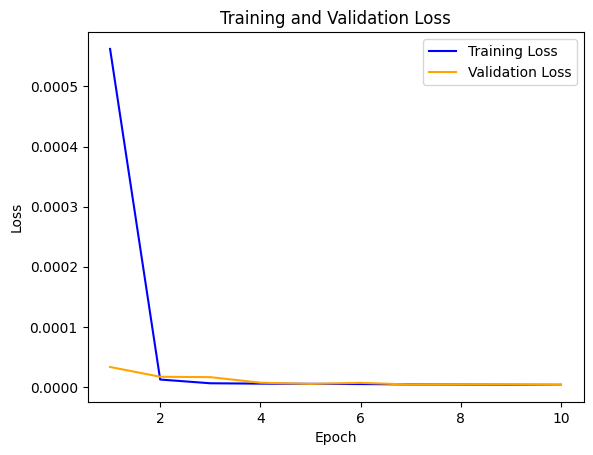

Checkerboard Input:
[[0.         0.         0.         0.         1.        ]
 [0.33333334 0.         0.6666667  0.33333334 0.6666667 ]
 [0.33333334 0.33333334 1.         0.         0.33333334]
 [0.33333334 0.6666667  0.         0.6666667  0.6666667 ]
 [0.6666667  1.         1.         1.         1.        ]]
Predicted Displacement (First 5 Nodes):
[[ 1.99044211e-04  1.26224826e-03 -5.07942587e-02]
 [ 2.60183850e-04  1.63570698e-03 -1.13209985e-01]
 [-9.34784111e-06  1.54775835e-03 -1.22590140e-01]
 [-4.03624799e-05  1.24030898e-03 -5.94385080e-02]
 [ 5.67580937e-05  9.75222443e-04 -1.66316591e-02]]
Ground Truth Displacement (First 5 Nodes):
[[ 2.9743594e-04  1.0944151e-03 -4.9465947e-02]
 [ 3.0933018e-04  1.6510081e-03 -1.1173451e-01]
 [ 1.7518032e-34  1.6893633e-03 -1.2097918e-01]
 [-4.3741406e-05  1.0141790e-03 -5.8439549e-02]
 [ 1.2582411e-04  8.1729016e-04 -1.9373873e-02]]
Overall Mean Squared Error (MSE) on Test Set: 0.0000035214


In [ ]:



# 1. Set Random State for Reproducibility
torch.manual_seed(2024)
np.random.seed(2024)

# 2. Dataset Class
class CheckerboardDataset(Dataset):
    def __init__(self, checkerboards, displacements):
        """
        Args:
            checkerboards (numpy array): Array of checkerboard patterns (batch_size, height, width).
            displacements (numpy array): Array of displacements (batch_size, num_nodes, 3).
        """
        self.checkerboards = checkerboards
        self.displacements = displacements
    
    def __len__(self):
        return len(self.checkerboards)
    
    def __getitem__(self, idx):
        checkerboard = self.checkerboards[idx]
        displacement = self.displacements[idx]
        
        # Add a channel dimension to checkerboard (1 channel) to match with CNN expectations
        checkerboard = torch.tensor(checkerboard, dtype=torch.float32).unsqueeze(0)  # (1, height, width)
        displacement = torch.tensor(displacement, dtype=torch.float32)  # (num_nodes, 3)
        
        return checkerboard, displacement

# 3. Normalization Function
class NormalizedDataset(Dataset):
    """
    A wrapper for normalizing datasets. Takes a base dataset and applies normalization to its features.
    """
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.checkerboards = torch.cat([data[0] for data in base_dataset], dim=0)  # Collect all checkerboards
        self.min_val = self.checkerboards.min()
        self.max_val = self.checkerboards.max()

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        checkerboard, displacement = self.base_dataset[idx]
        normalized_checkerboard = (checkerboard - self.min_val) / (self.max_val - self.min_val)
        return normalized_checkerboard, displacement

# Load and split the dataset
full_dataset = CheckerboardDataset(checkerboard1, displacements1)

# Split into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Wrap subsets with normalization
train_dataset = NormalizedDataset(train_dataset)
val_dataset = NormalizedDataset(val_dataset)
test_dataset = NormalizedDataset(test_dataset)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=15, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=15, shuffle=False)

# 4. Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=(2, 3), keepdim=True)  # Global average pooling
        max_pool = torch.max(torch.max(x, dim=2, keepdim=True).values, dim=3, keepdim=True).values  # Global max pooling
        scale = self.fc1(avg_pool) + self.fc1(max_pool)
        scale = self.fc2(torch.relu(scale))
        return self.sigmoid(scale) * x

# 5. Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)  # Channel-wise average
        max_pool = torch.max(x, dim=1, keepdim=True).values  # Channel-wise max
        scale = torch.cat([avg_pool, max_pool], dim=1)
        return self.sigmoid(self.conv1(scale)) * x




# 6. CNN Model with Attention Mechanisms
class DisplacementPredictor(nn.Module):
    def __init__(self, input_channels, num_nodes):
        super(DisplacementPredictor, self).__init__()
        
        # Convolutional layers for spatial feature extraction
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.ca1 = ChannelAttention(32)
        self.sa1 = SpatialAttention()
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.ca2 = ChannelAttention(64)
        self.sa2 = SpatialAttention()

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.ca3 = ChannelAttention(128)
        self.sa3 = SpatialAttention()
        
        # Fully connected layers for displacement prediction
        self.fc = nn.Sequential(
            nn.Linear(128 * 5 * 5, 512),  # Adjust based on flattened dimension after conv layers
            nn.ReLU(),
            nn.Linear(512, num_nodes * 3)  # Output size = num_nodes * 3 (displacement components)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.ca1(x)
        x = self.sa1(x)

        x = self.conv2(x)
        x = self.ca2(x)
        x = self.sa2(x)

        x = self.conv3(x)
        x = self.ca3(x)
        x = self.sa3(x)
        
        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        # Reshape output to (batch_size, num_nodes, 3)
        return x.view(x.size(0), -1, 3)



# 7. Model, Loss, and Optimizer
input_channels = 1  # Checkerboard has 1 channel
num_nodes = 5202  # Number of nodes
model = DisplacementPredictor(input_channels, num_nodes)

criterion = nn.MSELoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)  # Reduce LR every 2 epochs


# 6. Training Loop with Early Stopping and Plotting
epochs = 10
patience = 5  # Number of epochs to wait for improvement before stopping early
best_val_loss = float('inf')
early_stop_counter = 0

train_losses = []
val_losses = []

# Initialize plot
plt.ion()
fig, ax = plt.subplots()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
line1, = ax.plot([], [], label='Training Loss', color='blue')
line2, = ax.plot([], [], label='Validation Loss', color='orange')
ax.legend()

for epoch in range(epochs):
    # Training
    model.train()
    epoch_loss = 0.0

    for checkerboard, displacement in train_loader:
        optimizer.zero_grad()
        predicted_displacements = model(checkerboard)
        loss = criterion(predicted_displacements, displacement)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    scheduler.step()
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for checkerboard, displacement in val_loader:
            predicted_displacements = model(checkerboard)
            loss = criterion(predicted_displacements, displacement)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # Update plot
    line1.set_xdata(range(1, len(train_losses) + 1))
    line1.set_ydata(train_losses)
    line2.set_xdata(range(1, len(val_losses) + 1))
    line2.set_ydata(val_losses)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.10f}, Validation Loss: {val_loss:.10f}")

plt.ioff()
plt.show()

# 7. Testing and Viewing Predicted Results with MSE Calculation
model.eval()
total_mse = 0.0  # Initialize total MSE for all batches
batch_count = 0

with torch.no_grad():
    for checkerboard, displacement in test_loader:
        # Forward pass to get predictions
        predicted_displacements = model(checkerboard)
        
        # Calculate batch MSE
        batch_mse = criterion(predicted_displacements, displacement).item()  # Compute MSE loss for the batch
        total_mse += batch_mse
        batch_count += 1
        
        # Display results for the first batch
        if batch_count == 1:
            print("Checkerboard Input:")
            print(checkerboard[0][0].numpy())  # Show first checkerboard in the batch
            print("Predicted Displacement (First 5 Nodes):")
            print(predicted_displacements[0][:5].numpy())  # Predicted displacement for first 5 nodes
            print("Ground Truth Displacement (First 5 Nodes):")
            print(displacement[0][:5].numpy())  # Ground truth displacement for first 5 nodes

# Calculate and print overall MSE
overall_mse = total_mse / batch_count
print(f"Overall Mean Squared Error (MSE) on Test Set: {overall_mse:.10f}")


## MAE

Epoch 1/10, Training Loss: 0.0110213363, Validation Loss: 0.0036437713
Epoch 2/10, Training Loss: 0.0031219167, Validation Loss: 0.0030064166
Epoch 3/10, Training Loss: 0.0026024038, Validation Loss: 0.0023652878
Epoch 4/10, Training Loss: 0.0023375566, Validation Loss: 0.0022560464
Epoch 5/10, Training Loss: 0.0021953658, Validation Loss: 0.0020984669
Epoch 6/10, Training Loss: 0.0021715235, Validation Loss: 0.0020302058
Epoch 7/10, Training Loss: 0.0021299655, Validation Loss: 0.0020172379
Epoch 8/10, Training Loss: 0.0021238509, Validation Loss: 0.0020096256
Epoch 9/10, Training Loss: 0.0021014139, Validation Loss: 0.0019915796
Epoch 10/10, Training Loss: 0.0021104071, Validation Loss: 0.0020016307


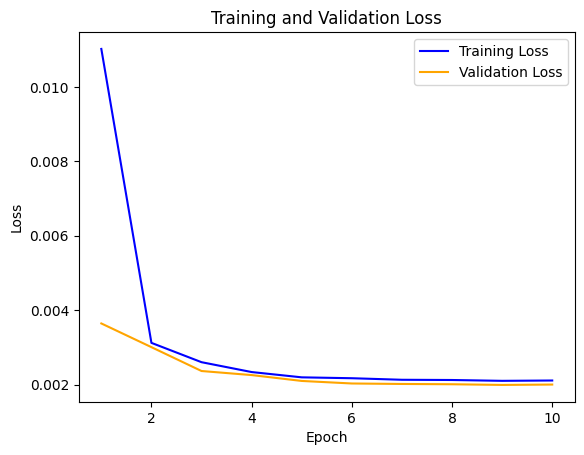

Checkerboard Input:
[[0.         0.         0.         0.         1.        ]
 [0.33333334 0.         0.6666667  0.33333334 0.6666667 ]
 [0.33333334 0.33333334 1.         0.         0.33333334]
 [0.33333334 0.6666667  0.         0.6666667  0.6666667 ]
 [0.6666667  1.         1.         1.         1.        ]]
Predicted Displacement (First 5 Nodes):
[[-2.25736760e-04  1.59080117e-03 -4.95905615e-02]
 [ 4.94755805e-05  1.17010879e-03 -1.16990685e-01]
 [-1.18607655e-04  1.26990932e-03 -1.29476368e-01]
 [ 3.62269580e-04  1.34462630e-03 -6.03445694e-02]
 [ 2.33516097e-04  1.03131169e-03 -1.52468551e-02]]
Ground Truth Displacement (First 5 Nodes):
[[ 2.9743594e-04  1.0944151e-03 -4.9465947e-02]
 [ 3.0933018e-04  1.6510081e-03 -1.1173451e-01]
 [ 1.7518032e-34  1.6893633e-03 -1.2097918e-01]
 [-4.3741406e-05  1.0141790e-03 -5.8439549e-02]
 [ 1.2582411e-04  8.1729016e-04 -1.9373873e-02]]
Overall Mean Absolute Error (MAE) on Test Set: 0.0022369011


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

# 1. Set Random State for Reproducibility
torch.manual_seed(2024)
np.random.seed(2024)

# 2. Dataset Class
class CheckerboardDataset(Dataset):
    def __init__(self, checkerboards, displacements):
        """
        Args:
            checkerboards (numpy array): Array of checkerboard patterns (batch_size, height, width).
            displacements (numpy array): Array of displacements (batch_size, num_nodes, 3).
        """
        self.checkerboards = checkerboards
        self.displacements = displacements
    
    def __len__(self):
        return len(self.checkerboards)
    
    def __getitem__(self, idx):
        checkerboard = self.checkerboards[idx]
        displacement = self.displacements[idx]
        
        # Add a channel dimension to checkerboard (1 channel) to match with CNN expectations
        checkerboard = torch.tensor(checkerboard, dtype=torch.float32).unsqueeze(0)  # (1, height, width)
        displacement = torch.tensor(displacement, dtype=torch.float32)  # (num_nodes, 3)
        
        return checkerboard, displacement

# 3. Normalization Function
class NormalizedDataset(Dataset):
    """
    A wrapper for normalizing datasets. Takes a base dataset and applies normalization to its features.
    """
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.checkerboards = torch.cat([data[0] for data in base_dataset], dim=0)  # Collect all checkerboards
        self.min_val = self.checkerboards.min()
        self.max_val = self.checkerboards.max()

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        checkerboard, displacement = self.base_dataset[idx]
        normalized_checkerboard = (checkerboard - self.min_val) / (self.max_val - self.min_val)
        return normalized_checkerboard, displacement

# Load and split the dataset
full_dataset = CheckerboardDataset(checkerboard1, displacements1)

# Split into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Wrap subsets with normalization
train_dataset = NormalizedDataset(train_dataset)
val_dataset = NormalizedDataset(val_dataset)
test_dataset = NormalizedDataset(test_dataset)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=15, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=15, shuffle=False)

# 4. Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=(2, 3), keepdim=True)  # Global average pooling
        max_pool = torch.max(torch.max(x, dim=2, keepdim=True).values, dim=3, keepdim=True).values  # Global max pooling
        scale = self.fc1(avg_pool) + self.fc1(max_pool)
        scale = self.fc2(torch.relu(scale))
        return self.sigmoid(scale) * x

# 5. Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)  # Channel-wise average
        max_pool = torch.max(x, dim=1, keepdim=True).values  # Channel-wise max
        scale = torch.cat([avg_pool, max_pool], dim=1)
        return self.sigmoid(self.conv1(scale)) * x

# 6. CNN Model with Attention Mechanisms
class DisplacementPredictor(nn.Module):
    def __init__(self, input_channels, num_nodes):
        super(DisplacementPredictor, self).__init__()
        
        # Convolutional layers for spatial feature extraction
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.ca1 = ChannelAttention(32)
        self.sa1 = SpatialAttention()
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.ca2 = ChannelAttention(64)
        self.sa2 = SpatialAttention()

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.ca3 = ChannelAttention(128)
        self.sa3 = SpatialAttention()
        
        # Fully connected layers for displacement prediction
        self.fc = nn.Sequential(
            nn.Linear(128 * 5 * 5, 512),  # Adjust based on flattened dimension after conv layers
            nn.ReLU(),
            nn.Linear(512, num_nodes * 3)  # Output size = num_nodes * 3 (displacement components)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.ca1(x)
        x = self.sa1(x)

        x = self.conv2(x)
        x = self.ca2(x)
        x = self.sa2(x)

        x = self.conv3(x)
        x = self.ca3(x)
        x = self.sa3(x)
        
        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        # Reshape output to (batch_size, num_nodes, 3)
        return x.view(x.size(0), -1, 3)

# 7. Model, Loss, and Optimizer
input_channels = 1  # Checkerboard has 1 channel
num_nodes = 5202  # Number of nodes
model = DisplacementPredictor(input_channels, num_nodes)

criterion = nn.L1Loss()  # Loss function (MAE)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)  # Reduce LR every 2 epochs

# 6. Training Loop with Early Stopping and Plotting
epochs = 10
patience = 5  # Number of epochs to wait for improvement before stopping early
best_val_loss = float('inf')
early_stop_counter = 0

train_losses = []
val_losses = []

# Initialize plot
plt.ion()
fig, ax = plt.subplots()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
line1, = ax.plot([], [], label='Training Loss', color='blue')
line2, = ax.plot([], [], label='Validation Loss', color='orange')
ax.legend()

for epoch in range(epochs):
    # Training
    model.train()
    epoch_loss = 0.0

    for checkerboard, displacement in train_loader:
        optimizer.zero_grad()
        predicted_displacements = model(checkerboard)
        loss = criterion(predicted_displacements, displacement)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    scheduler.step()
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for checkerboard, displacement in val_loader:
            predicted_displacements = model(checkerboard)
            loss = criterion(predicted_displacements, displacement)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # Update plot
    line1.set_xdata(range(1, len(train_losses) + 1))
    line1.set_ydata(train_losses)
    line2.set_xdata(range(1, len(val_losses) + 1))
    line2.set_ydata(val_losses)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.10f}, Validation Loss: {val_loss:.10f}")

plt.ioff()
plt.show()

# 7. Testing and Viewing Predicted Results with MAE Calculation
model.eval()
total_mae = 0.0  # Initialize total MAE for all batches
batch_count = 0

with torch.no_grad():
    for checkerboard, displacement in test_loader:
        # Forward pass to get predictions
        predicted_displacements = model(checkerboard)
        
        # Calculate batch MAE
        batch_mae = criterion(predicted_displacements, displacement).item()  # Compute MAE loss for the batch
        total_mae += batch_mae
        batch_count += 1
        
        # Display results for the first batch
        if batch_count == 1:
            print("Checkerboard Input:")
            print(checkerboard[0][0].numpy())  # Show first checkerboard in the batch
            print("Predicted Displacement (First 5 Nodes):")
            print(predicted_displacements[0][:5].numpy())  # Predicted displacement for first 5 nodes
            print("Ground Truth Displacement (First 5 Nodes):")
            print(displacement[0][:5].numpy())  # Ground truth displacement for first 5 nodes

# Calculate and print overall MAE
overall_mae = total_mae / batch_count
print(f"Overall Mean Absolute Error (MAE) on Test Set: {overall_mae:.10f}")
